In [15]:
"""
dqn
"""
import os
import jax
import jax.numpy as jnp

import equinox as eqx
import numpy as np
import popjym
import equinox.nn as nn
from typing import Tuple, Callable, Any
from popjym.model.ResNet import ResNet, resnet18
from jaxtyping import PRNGKeyArray, Array
from popjym.wrappers import LogWrapper
import flashbax as fbx
import optax
import wandb
import chex
from popjym.model.utils import filter_scan

class QNetwork(eqx.Module):
    action_dim: int
    cnn: ResNet
    dense1: nn.Linear
    dense2: nn.Linear
    dense3: nn.Linear
    dense4: nn.Linear
    # dense5: nn.Linear
    activation: str = "tanh"

    def __init__(self, key: PRNGKeyArray, action_dim: int):
        self.action_dim = action_dim
        key_array = jax.random.split(key, 5)
        self.cnn = resnet18(key=key_array[0], make_with_state=False)

        self.dense1 = nn.Linear(in_features=512, out_features=256, key=key_array[1])
        self.dense2 = nn.Linear(in_features=256, out_features=128, key=key_array[2])
        self.dense3 = nn.Linear(in_features=128, out_features=64, key=key_array[3])
        self.dense4 = nn.Linear(in_features=64, out_features=action_dim, key=key_array[4])
        if self.activation == "relu":
            self.activation = jax.nn.leaky_relu
        else:
            self.activation = jax.nn.tanh
    
    def __call__(self, x: Array, state: nn.State) -> Tuple:
        x, state = self.cnn(x, state)
        x = self.dense1(x)
        x = self.activation(x)
        x = self.dense2(x)
        x = self.activation(x)
        x = self.dense3(x)
        x = self.activation(x)
        x = self.dense4(x)

        return x, state


@chex.dataclass(frozen=True)
class TimeStep:
    obs: Array
    action: Array
    reward: Array
    done: Array


class AgentModel(eqx.Module):
    q_network: QNetwork
    q_network_state: nn.State
    q_network_params: optax.OptState

    target_q_network: QNetwork
    target_q_network_state: nn.State
    target_q_network_params: optax.OptState

class CustomTrainState(eqx.Module):
    model: AgentModel
    q_opt_state: optax.OptState
    target_q_opt_state: optax.OptState
    tx: optax.GradientTransformation
    timesteps: int
    n_updates: int

    def __init__(
        self,
        model: AgentModel = None,
        q_opt_state: optax.OptState = None,
        target_q_opt_state: optax.OptState = None,
        tx: optax.GradientTransformation = None,
        timesteps: int = 0,
        n_updates: int = 0,
    ):
        self.model = model
        self.q_opt_state = q_opt_state
        self.target_q_opt_state = target_q_opt_state
        self.tx = tx
        self.timesteps = timesteps
        self.n_updates = n_updates

    @classmethod
    def create(
        cls,
        network: QNetwork,
        state: Any,
        network_params: Any,
        tx: optax.GradientTransformation
    ) -> 'CustomTrainState':
        """Factory method to create a new instance"""
        model = AgentModel(
            q_network=network,
            q_network_state=state,
            q_network_params=network_params,
            target_q_network=network,
            target_q_network_state=state,
            target_q_network_params=jax.tree.map(lambda x: jnp.copy(x), network_params)
        )
        
        q_opt_state = tx.init(network_params)
        target_q_opt_state = tx.init(network_params)
        
        return cls(
            model=model,
            q_opt_state=q_opt_state,
            target_q_opt_state=target_q_opt_state,
            tx=tx,
            timesteps=0,
            n_updates=0
        )

    def apply_gradients(self, grads: Any) -> 'CustomTrainState':
        """Apply gradients to update the model"""
        updates, new_q_opt_state = self.tx.update(grads, self.q_opt_state, self.model.q_network_params)
        new_params = optax.apply_updates(self.model.q_network_params, updates)
        
        new_model = eqx.tree_at(
            lambda m: (m.q_network_params,),
            self.model,
            (new_params,)
        )
        
        return self.__class__(
            model=new_model,
            q_opt_state=new_q_opt_state,
            target_q_opt_state=self.target_q_opt_state,
            tx=self.tx,
            timesteps=self.timesteps,
            n_updates=self.n_updates
        )
    
    def replace(self, **kwargs) -> 'CustomTrainState':
        """Replace attributes with new values"""
        current_dict = {
            'model': self.model,
            'q_opt_state': self.q_opt_state,
            'target_q_opt_state': self.target_q_opt_state,
            'tx': self.tx,
            'timesteps': self.timesteps,
            'n_updates': self.n_updates
        }
        current_dict.update(kwargs)
        return self.__class__(**current_dict)


def make_train(config):
    config["NUM_UPDATES"] = config["TOTAL_TIMESTEPS"] // config["NUM_ENVS"]

    basic_env, env_params = popjym.make(config["ENV_NAME"])
    # env = FlattenObservationWrapper(basic_env)
    env = LogWrapper(basic_env)

    vmap_reset = lambda n_envs: lambda rng: jax.vmap(env.reset, in_axes=(0, None))(
        jax.random.split(rng, n_envs), env_params
    )
    vmap_step = lambda n_envs: lambda rng, env_state, action: jax.vmap(
        env.step, in_axes=(0, 0, 0, None)
    )(jax.random.split(rng, n_envs), env_state, action, env_params)
    
    def train(rng):
        rng, _rng = jax.random.split(rng)
        init_obs, env_state = vmap_reset(config["NUM_ENVS"])(_rng)
        render = popjym.make_render(config["ENV_RENDER"])
        vmap_render = jax.vmap(render.render, in_axes=0)
        rendered_init_obs = vmap_render(env_state.env_state)
        rendered_init_obs = jnp.transpose(rendered_init_obs, (0, 3, 1, 2))

        buffer = fbx.make_flat_buffer(
            max_length = config["BUFFER_SIZE"],
            min_length=config["BUFFER_BATCH_SIZE"],
            sample_batch_size=config["BUFFER_BATCH_SIZE"],
            add_sequences=False,
            add_batch_size=config["NUM_ENVS"],
        )
        buffer = buffer.replace(
            init=jax.jit(buffer.init),
            add=jax.jit(buffer.add, donate_argnums=0),
            sample=jax.jit(buffer.sample),
            can_sample=jax.jit(buffer.can_sample),
        )
        rng = jax.random.PRNGKey(0)  # use a dummy rng here
        _action = basic_env.action_space().sample(rng)
        _, _env_state = env.reset(rng, env_params)
        _obs, _state, _reward, _done, _ = env.step(rng, _env_state, _action, env_params)
        print(f"_state: {_state}")
        _obs = render.render(_state.env_state)
        _obs = jnp.transpose(_obs, (2, 0, 1))
        _timestep = TimeStep(obs=_obs, action=_action, reward=_reward, done=_done)
        buffer_state = buffer.init(_timestep)

        # INIT NETWORK AND OPTIMIZER
        network, state = nn.make_with_state(QNetwork)(rng, env.action_space(env_params).n)

        def linear_schedule(count):
            frac = 1.0 - (count / config["NUM_UPDATES"])
            return config["LR"] * frac

        lr = linear_schedule if config.get("LR_LINEAR_DECAY", False) else config["LR"]
        tx = optax.adamw(learning_rate=lr)
        # TODO opt_state = optimizer.init(eqx.filter(rnn, eqx.is_array))

        # network_params = jax.tree.flatten(network)
        network_params = eqx.filter(network, eqx.is_inexact_array)
        
        # train_state = CustomTrainState()
        # train_state.model = AgentModel(
        #     q_network=network, 
        #     q_network_state=state,
        #     q_network_params=network_params,
        #     target_q_network_state=state, 
        #     target_q_network=network,
        #     target_q_network_params=jax.tree_map(lambda x: jnp.copy(x), network_params),
        # )
        # train_state.q_opt_state = tx.init(network_params)
        # train_state.target_q_opt_state = tx.init(network_params)
        render = popjym.make_render(config["ENV_RENDER"])
        vmap_render = jax.vmap(render.render, in_axes=0)
        obs = vmap_render(env_state.env_state)
        obs = jnp.transpose(obs, (0, 3, 1, 2))

        train_state = CustomTrainState.create(
            network=network,
            state=state,
            network_params=network_params,
            tx=tx
        )
        # vmap_network = jax.vmap(network, axis_name="batch", in_axes=(0, None), out_axes=(0, None))
        # train_state.apply_fn = vmap_network
        # tx = tx
        # train_state.timesteps = 0
        # train_state.n_updates = 0

        # epsilon-greedy exploration
        def eps_greedy_exploration(rng, q_vals, t):
            rng_a, rng_e = jax.random.split(
                rng, 2
            )  # a key for sampling random actions and one for picking
            eps = jnp.clip(  # get epsilon
                (
                    (config["EPSILON_FINISH"] - config["EPSILON_START"])
                    / config["EPSILON_ANNEAL_TIME"]
                )
                * t
                + config["EPSILON_START"],
                config["EPSILON_FINISH"],
            )
            greedy_actions = jnp.argmax(q_vals, axis=-1)  # get the greedy actions
            chosed_actions = jnp.where(
                jax.random.uniform(rng_e, greedy_actions.shape)
                < eps,  # pick the actions that should be random
                jax.random.randint(
                    rng_a, shape=greedy_actions.shape, minval=0, maxval=q_vals.shape[-1]
                ),  # sample random actions,
                greedy_actions,
            )
            return chosed_actions


        # TRAINING LOOP
        def _update_step(runner_state, unused):
            train_state, buffer_state, env_state, last_obs, rng = runner_state
            # print(f"last obs: {last_obs.shape}") # (10, 3, 256, 256)
            rng, rng_a, rng_s = jax.random.split(rng, 3)

            # 使用 eqx.filter_vmap 而不是直接使用 jax.vmap
            vmap_network = eqx.filter_vmap(train_state.model.q_network)
            q_vals, model_state = vmap_network(last_obs, train_state.model.q_network_state)
            # print(f"last obs: {last_obs.shape}") # (10, 3, 256, 256)

            action = eps_greedy_exploration(rng_a, q_vals, train_state.timesteps)
            obs, env_state, reward, done, info = vmap_step(config["NUM_ENVS"])(rng_s, env_state, action)
            obs = vmap_render(env_state.env_state)
            obs = jnp.transpose(obs, (0, 3, 1, 2))
            # timesteps = train_state.timesteps + config["NUM_ENVS"]
            # train_state.timesteps = timesteps
            train_state = train_state.replace(
                timesteps = train_state.timesteps + config["NUM_ENVS"]
            )
            timestep = TimeStep(obs=last_obs, action=action, reward=reward, done=done)
            buffer_state = buffer.add(buffer_state, timestep)
            
            # networks update
            def _learn_phase(train_state, rng):
                learn_batch = buffer.sample(buffer_state, rng).experience

                # q_next_target, _ = train_state.apply_fn(learn_batch.second.obs, train_state.model.target_q_network_state)
                # 对目标网络使用 eqx.filter_vmap
                vmap_target = eqx.filter_vmap(train_state.model.target_q_network)
                q_next_target, _ = vmap_target(learn_batch.second.obs, 
                                         train_state.model.target_q_network_state)
            
                q_next_target = jnp.max(q_next_target, axis=-1) # (batch_size, )
                target = (
                    learn_batch.first.reward + (1 - learn_batch.first.done) * config["GAMMA"] * q_next_target
                )

                def _loss_fn(params):
                    # q_vals, _ = train_state.apply_fn(learn_batch.first.obs, params) # params should be network_state instead of network_params
                    # 在损失函数中使用 eqx.filter_vmap
                    network = eqx.tree_at(lambda m: m.q_network_params, 
                                    train_state.model.q_network, params)
                    vmap_q = eqx.filter_vmap(network)
                    q_vals, _ = vmap_q(learn_batch.first.obs, 
                                 train_state.model.q_network_state)
                
                    chosen_action_qvals = jnp.take_along_axis(
                        q_vals,
                        jnp.expand_dims(learn_batch.first.action, axis=-1),
                        axis=-1,
                    ).squeeze(axis=-1)
                    return jnp.mean((chosen_action_qvals - target) ** 2)
                
                loss, grads = jax.value_and_grad(_loss_fn)(train_state.model.q_network_params)
                train_state = train_state.apply_gradients(grads=grads)
                train_state = train_state.replace(n_updates=train_state.n_updates + 1)
                return train_state, loss
            rng, _rng = jax.random.split(rng)
            is_learn_time = (
                (buffer.can_sample(buffer_state))
                & (  # enough experience in buffer
                    train_state.timesteps > config["LEARNING_STARTS"]
                )
                & (  # pure exploration phase ended
                    train_state.timesteps % config["TRAINING_INTERVAL"] == 0
                )  # training interval
            )
            train_state, loss = jax.lax.cond(
                is_learn_time,
                lambda train_state, rng: _learn_phase(train_state, rng),
                lambda train_state, rng: (train_state, jnp.array(0.0)),  # do nothing
                train_state,
                _rng,
            )

            # update target network
            train_state = jax.lax.cond(
                train_state.timesteps % config["TARGET_UPDATE_INTERVAL"] == 0,
                lambda train_state: train_state.replace(
                    target_network_params=optax.incremental_update(
                        train_state.model.q_network_params,
                        train_state.model.target_q_network_params,
                        config["TAU"],
                    )
                ),
                lambda train_state: train_state,
                operand=train_state,
            )

            metrics = {
                "timesteps": train_state.timesteps,
                "updates": train_state.n_updates,
                "loss": loss.mean(),
                "returns": info["returned_episode_returns"].mean(),
            }
            # report on wandb if required
            if config.get("WANDB_MODE", "disabled") == "online":

                def callback(metrics):
                    if metrics["timesteps"] % 100 == 0:
                        wandb.log(metrics)

                jax.debug.callback(callback, metrics)

            runner_state = (train_state, buffer_state, env_state, obs, rng)

            return runner_state, metrics

        # train
        rng, _rng = jax.random.split(rng)
        runner_state = (train_state, buffer_state, env_state, rendered_init_obs, _rng)

        runner_state, metrics = filter_scan(
            _update_step, runner_state, None, config["NUM_UPDATES"]
        )

        return {"runner_state": runner_state, "metrics": metrics}
    return train

def main():
    config = {
        "NUM_ENVS": 10,
        "BUFFER_SIZE": 10000,
        "BUFFER_BATCH_SIZE": 128,
        "TOTAL_TIMESTEPS": 5e5,
        "EPSILON_START": 1.0,
        "EPSILON_FINISH": 0.05,
        "EPSILON_ANNEAL_TIME": 25e4,
        "TARGET_UPDATE_INTERVAL": 500,
        "LR": 2.5e-4,
        "LEARNING_STARTS": 10000,
        "TRAINING_INTERVAL": 10,
        "LR_LINEAR_DECAY": False,
        "GAMMA": 0.99,
        "TAU": 1.0,
        "ENV_NAME": "CountRecallEasy",
        "ENV_RENDER": "CountRecallRender",
        "SEED": 0,
        "NUM_SEEDS": 1,
        "WANDB_MODE": "disabled",  # set to online to activate wandb
        "ENTITY": "",
        "PROJECT": "",
    }
    # train = make_train(config)
    # train(jax.random.PRNGKey(0))
    wandb.init(
        entity=config["ENTITY"],
        project=config["PROJECT"],
        tags=["DQN", config["ENV_NAME"].upper(), f"jax_{jax.__version__}"],
        name=f'purejaxrl_dqn_{config["ENV_NAME"]}',
        config=config,
        mode=config["WANDB_MODE"],
    )

    # key = jax.random.PRNGKey(1)
    # x = jax.random.normal(jax.random.PRNGKey(0), shape=(2, 3, 256, 256))
    
    # env, env_params= popjym.make("CartPole")
    # qnet, state = nn.make_with_state(QNetwork)(key, env.action_space(env_params).n)
    # print(env.action_space(env_params).n)
    # # qnet = QNetwork(key, env.action_space(env_params).n)
    # batch_qnet = jax.vmap(qnet, axis_name="batch", in_axes=(0, None), out_axes=(0, None))
    # y_pred, state = batch_qnet(x, state)
    # print(y_pred.shape)


    rng = jax.random.PRNGKey(config["SEED"])
    rngs = jax.random.split(rng, config["NUM_SEEDS"])
    train_vjit = jax.jit(jax.vmap(make_train(config)))
    outs = jax.block_until_ready(train_vjit(rngs))

if __name__ == "__main__":
    main()

f:\Anaconda\envs\JaxEnv\Lib\site-packages\flashbax\buffers\trajectory_buffer.py:473: UserWarning: Setting max_size dynamically sets the `max_length_time_axis` to be `max_size`//`add_batch_size = 1000`.This allows one to control exactly how many timesteps are stored in the buffer.Note that this overrides the `max_length_time_axis` argument.
  warnings.warn(
f:\Anaconda\envs\JaxEnv\Lib\site-packages\jax\_src\numpy\array_methods.py:118: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  return lax_numpy.astype(self, dtype, copy=copy, device=device)


_state: LogEnvState(env_state=EnvState(timestep=Traced<ShapedArray(int32[], weak_type=True)>with<DynamicJaxprTrace(level=1/0)>, value_cards=Traced<ShapedArray(int32[52])>with<DynamicJaxprTrace(level=1/0)>, query_cards=Traced<ShapedArray(int32[52])>with<DynamicJaxprTrace(level=1/0)>, running_count=Traced<ShapedArray(float32[2])>with<DynamicJaxprTrace(level=1/0)>, history=Traced<ShapedArray(float32[52])>with<DynamicJaxprTrace(level=1/0)>, default_action=Traced<ShapedArray(int32[], weak_type=True)>with<DynamicJaxprTrace(level=1/0)>, num_types=Traced<ShapedArray(int32[], weak_type=True)>with<DynamicJaxprTrace(level=1/0)>, score=Traced<ShapedArray(int32[], weak_type=True)>with<DynamicJaxprTrace(level=1/0)>), episode_returns=Traced<ShapedArray(float32[], weak_type=True)>with<DynamicJaxprTrace(level=1/0)>, episode_lengths=Traced<ShapedArray(int32[], weak_type=True)>with<DynamicJaxprTrace(level=1/0)>, returned_episode_returns=Traced<ShapedArray(float32[], weak_type=True)>with<DynamicJaxprTrace

ValueError: vmap was requested to map its argument along axis 0, which implies that its rank should be at least 1, but is only 0 (its shape is ())

# Above is just for test TrainState and it will delete later

In [8]:
"""
dqn
"""
import os
import jax
import jax.numpy as jnp

import equinox as eqx
import numpy as np
import popjym
import equinox.nn as nn
from typing import Tuple, Callable, Any
from popjym.model.ResNet import ResNet, resnet18
from jaxtyping import PRNGKeyArray, Array
from popjym.wrappers import LogWrapper
import flashbax as fbx
import optax
import wandb
import chex
from popjym.model.utils import filter_scan

class QNetwork(eqx.Module):
    action_dim: int
    cnn: ResNet
    dense1: nn.Linear
    dense2: nn.Linear
    dense3: nn.Linear
    dense4: nn.Linear
    # dense5: nn.Linear
    activation: str = "tanh"

    def __init__(self, key: PRNGKeyArray, action_dim: int):
        self.action_dim = action_dim
        key_array = jax.random.split(key, 5)
        self.cnn = resnet18(key=key_array[0], make_with_state=False)

        self.dense1 = nn.Linear(in_features=512, out_features=256, key=key_array[1])
        self.dense2 = nn.Linear(in_features=256, out_features=128, key=key_array[2])
        self.dense3 = nn.Linear(in_features=128, out_features=64, key=key_array[3])
        self.dense4 = nn.Linear(in_features=64, out_features=action_dim, key=key_array[4])
        if self.activation == "relu":
            self.activation = jax.nn.leaky_relu
        else:
            self.activation = jax.nn.tanh
    
    def __call__(self, x: Array, state: nn.State) -> Tuple:
        x, state = self.cnn(x, state)
        x = self.dense1(x)
        x = self.activation(x)
        x = self.dense2(x)
        x = self.activation(x)
        x = self.dense3(x)
        x = self.activation(x)
        x = self.dense4(x)

        return x, state


@chex.dataclass(frozen=True)
class TimeStep:
    obs: Array
    action: Array
    reward: Array
    done: Array


class AgentModel(eqx.Module):
    q_network: QNetwork
    q_network_state: nn.State
    q_network_params: optax.OptState

    target_q_network: QNetwork
    target_q_network_state: nn.State
    target_q_network_params: optax.OptState

class CustomTrainState(eqx.Module):
    model: AgentModel
    q_opt_state: optax.OptState
    target_q_opt_state: optax.OptState
    tx: optax.GradientTransformation
    apply_fn: Callable
    timesteps: int
    n_updates: int

    def __init__(
        self,
        model: AgentModel = None,
        q_opt_state: optax.OptState = None,
        target_q_opt_state: optax.OptState = None,
        tx: optax.GradientTransformation = None,
        apply_fn: Callable = None,
        timesteps: int = 0,
        n_updates: int = 0,
    ):
        self.model = model
        self.q_opt_state = q_opt_state
        self.target_q_opt_state = target_q_opt_state
        self.tx = tx
        self.apply_fn = apply_fn
        self.timesteps = timesteps
        self.n_updates = n_updates

    @classmethod
    def create(
        cls,
        network: QNetwork,
        state: Any,
        network_params: Any,
        tx: optax.GradientTransformation
    ) -> 'CustomTrainState':
        """Factory method to create a new instance"""
        # 创建新的模型
        model = AgentModel(
            q_network=network,
            q_network_state=state,
            q_network_params=network_params,
            target_q_network=network,
            target_q_network_state=state,
            target_q_network_params=jax.tree.map(lambda x: jnp.copy(x), network_params)
        )
        
        # 初始化优化器状态
        q_opt_state = tx.init(network_params)
        target_q_opt_state = tx.init(network_params)
        
        # 创建vmapped网络
        vmap_network = jax.vmap(network, axis_name="batch", in_axes=(0, None), out_axes=(0, None))
        
        # 创建并返回新的训练状态
        return cls(
            model=model,
            q_opt_state=q_opt_state,
            target_q_opt_state=target_q_opt_state,
            tx=tx,
            apply_fn=vmap_network,
            timesteps=0,
            n_updates=0
        )

    def apply_gradients(self, grads: Any) -> 'CustomTrainState':
        """Apply gradients to update the model"""
        updates, new_q_opt_state = self.tx.update(grads, self.q_opt_state, self.model.q_network_params)
        new_params = optax.apply_updates(self.model.q_network_params, updates)
        
        # 更新模型参数
        new_model = eqx.tree_at(
            lambda m: (m.q_network_params,),
            self.model,
            (new_params,)
        )
        
        # 创建新的训练状态
        return self.__class__(
            model=new_model,
            q_opt_state=new_q_opt_state,
            target_q_opt_state=self.target_q_opt_state,
            tx=self.tx,
            apply_fn=self.apply_fn,
            timesteps=self.timesteps,
            n_updates=self.n_updates
        )
    
    def replace(self, **kwargs) -> 'CustomTrainState':
        """Replace attributes with new values"""
        current_dict = {
            'model': self.model,
            'q_opt_state': self.q_opt_state,
            'target_q_opt_state': self.target_q_opt_state,
            'tx': self.tx,
            'apply_fn': self.apply_fn,
            'timesteps': self.timesteps,
            'n_updates': self.n_updates
        }
        # 更新指定的属性
        current_dict.update(kwargs)
        
        # 创建新实例
        return self.__class__(**current_dict)



def make_train(config):
    config["NUM_UPDATES"] = config["TOTAL_TIMESTEPS"] // config["NUM_ENVS"]

    basic_env, env_params = popjym.make(config["ENV_NAME"])
    # env = FlattenObservationWrapper(basic_env)
    env = LogWrapper(basic_env)

    vmap_reset = lambda n_envs: lambda rng: jax.vmap(env.reset, in_axes=(0, None))(
        jax.random.split(rng, n_envs), env_params
    )
    vmap_step = lambda n_envs: lambda rng, env_state, action: jax.vmap(
        env.step, in_axes=(0, 0, 0, None)
    )(jax.random.split(rng, n_envs), env_state, action, env_params)
    
    def train(rng):
        rng, _rng = jax.random.split(rng)
        init_obs, env_state = vmap_reset(config["NUM_ENVS"])(_rng)
        render = popjym.make_render(config["ENV_RENDER"])
        vmap_render = jax.vmap(render.render, in_axes=0)
        rendered_init_obs = vmap_render(env_state.env_state)
        rendered_init_obs = jnp.transpose(rendered_init_obs, (0, 3, 1, 2))

        buffer = fbx.make_flat_buffer(
            max_length = config["BUFFER_SIZE"],
            min_length=config["BUFFER_BATCH_SIZE"],
            sample_batch_size=config["BUFFER_BATCH_SIZE"],
            add_sequences=False,
            add_batch_size=config["NUM_ENVS"],
        )
        buffer = buffer.replace(
            init=jax.jit(buffer.init),
            add=jax.jit(buffer.add, donate_argnums=0),
            sample=jax.jit(buffer.sample),
            can_sample=jax.jit(buffer.can_sample),
        )
        rng = jax.random.PRNGKey(0)  # use a dummy rng here
        _action = basic_env.action_space().sample(rng)
        _, _env_state = env.reset(rng, env_params)
        _obs, _state, _reward, _done, _ = env.step(rng, _env_state, _action, env_params)
        print(f"_state: {_state}")
        _obs = render.render(_state.env_state)
        _obs = jnp.transpose(_obs, (2, 0, 1))
        _timestep = TimeStep(obs=_obs, action=_action, reward=_reward, done=_done)
        buffer_state = buffer.init(_timestep)

        # INIT NETWORK AND OPTIMIZER
        network, state = nn.make_with_state(QNetwork)(rng, env.action_space(env_params).n)

        def linear_schedule(count):
            frac = 1.0 - (count / config["NUM_UPDATES"])
            return config["LR"] * frac

        lr = linear_schedule if config.get("LR_LINEAR_DECAY", False) else config["LR"]
        tx = optax.adamw(learning_rate=lr)
        # TODO opt_state = optimizer.init(eqx.filter(rnn, eqx.is_array))

        # network_params = jax.tree.flatten(network)
        network_params = eqx.filter(network, eqx.is_inexact_array)
        
        # train_state = CustomTrainState()
        # train_state.model = AgentModel(
        #     q_network=network, 
        #     q_network_state=state,
        #     q_network_params=network_params,
        #     target_q_network_state=state, 
        #     target_q_network=network,
        #     target_q_network_params=jax.tree_map(lambda x: jnp.copy(x), network_params),
        # )
        # train_state.q_opt_state = tx.init(network_params)
        # train_state.target_q_opt_state = tx.init(network_params)
        render = popjym.make_render(config["ENV_RENDER"])
        vmap_render = jax.vmap(render.render, in_axes=0)
        obs = vmap_render(env_state.env_state)
        obs = jnp.transpose(obs, (0, 3, 1, 2))

        train_state = CustomTrainState.create(
            network=network,
            state=state,
            network_params=network_params,
            tx=tx
        )
        # vmap_network = jax.vmap(network, axis_name="batch", in_axes=(0, None), out_axes=(0, None))
        # train_state.apply_fn = vmap_network
        # tx = tx
        # train_state.timesteps = 0
        # train_state.n_updates = 0

        # epsilon-greedy exploration
        def eps_greedy_exploration(rng, q_vals, t):
            rng_a, rng_e = jax.random.split(
                rng, 2
            )  # a key for sampling random actions and one for picking
            eps = jnp.clip(  # get epsilon
                (
                    (config["EPSILON_FINISH"] - config["EPSILON_START"])
                    / config["EPSILON_ANNEAL_TIME"]
                )
                * t
                + config["EPSILON_START"],
                config["EPSILON_FINISH"],
            )
            greedy_actions = jnp.argmax(q_vals, axis=-1)  # get the greedy actions
            chosed_actions = jnp.where(
                jax.random.uniform(rng_e, greedy_actions.shape)
                < eps,  # pick the actions that should be random
                jax.random.randint(
                    rng_a, shape=greedy_actions.shape, minval=0, maxval=q_vals.shape[-1]
                ),  # sample random actions,
                greedy_actions,
            )
            return chosed_actions


        # TRAINING LOOP
        def _update_step(runner_state, unused):
            train_state, buffer_state, env_state, last_obs, rng = runner_state
            print(f"last obs: {last_obs.shape}")
            rng, rng_a, rng_s = jax.random.split(rng, 3)
            q_vals, model_state = train_state.apply_fn(last_obs, train_state.model.q_network_state)
            print(f"last obs: {last_obs.shape}")
            action = eps_greedy_exploration(rng_a, q_vals, train_state.timesteps)
            obs, env_state, reward, done, info = vmap_step(config["NUM_ENVS"])(rng_s, env_state, action)
            # timesteps = train_state.timesteps + config["NUM_ENVS"]
            # train_state.timesteps = timesteps
            train_state = train_state.replace(
                timesteps = train_state.timesteps + config["NUM_ENVS"]
            )
            timestep = TimeStep(obs=last_obs, action=action, reward=reward, done=done)
            buffer_state = buffer.add(buffer_state, timestep)
            
            # networks update
            def _learn_phase(train_state, rng):
                learn_batch = buffer.sample(buffer_state, rng).experience

                q_next_target, _ = train_state.apply_fn(learn_batch.second.obs, train_state.model.target_q_network_state)
                q_next_target = jnp.max(q_next_target, axis=-1) # (batch_size, )
                target = (
                    learn_batch.first.reward + (1 - learn_batch.first.done) * config["GAMMA"] * q_next_target
                )

                def _loss_fn(params):
                    q_vals, _ = train_state.apply_fn(learn_batch.first.obs, params) # params should be network_state instead of network_params
                    chosen_action_qvals = jnp.take_along_axis(
                        q_vals,
                        jnp.expand_dims(learn_batch.first.action, axis=-1),
                        axis=-1,
                    ).squeeze(axis=-1)
                    return jnp.mean((chosen_action_qvals - target) ** 2)
                
                loss, grads = jax.value_and_grad(_loss_fn)(train_state.model.q_network_params)
                train_state = train_state.apply_gradients(grads=grads)
                train_state = train_state.replace(n_updates=train_state.n_updates + 1)
                return train_state, loss
            rng, _rng = jax.random.split(rng)
            is_learn_time = (
                (buffer.can_sample(buffer_state))
                & (  # enough experience in buffer
                    train_state.timesteps > config["LEARNING_STARTS"]
                )
                & (  # pure exploration phase ended
                    train_state.timesteps % config["TRAINING_INTERVAL"] == 0
                )  # training interval
            )
            train_state, loss = jax.lax.cond(
                is_learn_time,
                lambda train_state, rng: _learn_phase(train_state, rng),
                lambda train_state, rng: (train_state, jnp.array(0.0)),  # do nothing
                train_state,
                _rng,
            )

            # update target network
            train_state = jax.lax.cond(
                train_state.timesteps % config["TARGET_UPDATE_INTERVAL"] == 0,
                lambda train_state: train_state.replace(
                    target_network_params=optax.incremental_update(
                        train_state.model.q_network_params,
                        train_state.model.target_q_network_params,
                        config["TAU"],
                    )
                ),
                lambda train_state: train_state,
                operand=train_state,
            )

            metrics = {
                "timesteps": train_state.timesteps,
                "updates": train_state.n_updates,
                "loss": loss.mean(),
                "returns": info["returned_episode_returns"].mean(),
            }
            # report on wandb if required
            if config.get("WANDB_MODE", "disabled") == "online":

                def callback(metrics):
                    if metrics["timesteps"] % 100 == 0:
                        wandb.log(metrics)

                jax.debug.callback(callback, metrics)

            runner_state = (train_state, buffer_state, env_state, obs, rng)

            return runner_state, metrics

        # train
        rng, _rng = jax.random.split(rng)
        runner_state = (train_state, buffer_state, env_state, rendered_init_obs, _rng)

        runner_state, metrics = filter_scan(
            _update_step, runner_state, None, config["NUM_UPDATES"]
        )

        return {"runner_state": runner_state, "metrics": metrics}
    return train

def main():
    config = {
        "NUM_ENVS": 10,
        "BUFFER_SIZE": 10000,
        "BUFFER_BATCH_SIZE": 128,
        "TOTAL_TIMESTEPS": 5e5,
        "EPSILON_START": 1.0,
        "EPSILON_FINISH": 0.05,
        "EPSILON_ANNEAL_TIME": 25e4,
        "TARGET_UPDATE_INTERVAL": 500,
        "LR": 2.5e-4,
        "LEARNING_STARTS": 10000,
        "TRAINING_INTERVAL": 10,
        "LR_LINEAR_DECAY": False,
        "GAMMA": 0.99,
        "TAU": 1.0,
        "ENV_NAME": "CountRecallEasy",
        "ENV_RENDER": "CountRecallRender",
        "SEED": 0,
        "NUM_SEEDS": 1,
        "WANDB_MODE": "disabled",  # set to online to activate wandb
        "ENTITY": "",
        "PROJECT": "",
    }
    # train = make_train(config)
    # train(jax.random.PRNGKey(0))
    wandb.init(
        entity=config["ENTITY"],
        project=config["PROJECT"],
        tags=["DQN", config["ENV_NAME"].upper(), f"jax_{jax.__version__}"],
        name=f'purejaxrl_dqn_{config["ENV_NAME"]}',
        config=config,
        mode=config["WANDB_MODE"],
    )

    # key = jax.random.PRNGKey(1)
    # x = jax.random.normal(jax.random.PRNGKey(0), shape=(2, 3, 256, 256))
    
    # env, env_params= popjym.make("CartPole")
    # qnet, state = nn.make_with_state(QNetwork)(key, env.action_space(env_params).n)
    # print(env.action_space(env_params).n)
    # # qnet = QNetwork(key, env.action_space(env_params).n)
    # batch_qnet = jax.vmap(qnet, axis_name="batch", in_axes=(0, None), out_axes=(0, None))
    # y_pred, state = batch_qnet(x, state)
    # print(y_pred.shape)


    rng = jax.random.PRNGKey(config["SEED"])
    rngs = jax.random.split(rng, config["NUM_SEEDS"])
    train_vjit = jax.jit(jax.vmap(make_train(config)))
    outs = jax.block_until_ready(train_vjit(rngs))

if __name__ == "__main__":
    main()

f:\Anaconda\envs\JaxEnv\Lib\site-packages\flashbax\buffers\trajectory_buffer.py:473: UserWarning: Setting max_size dynamically sets the `max_length_time_axis` to be `max_size`//`add_batch_size = 1000`.This allows one to control exactly how many timesteps are stored in the buffer.Note that this overrides the `max_length_time_axis` argument.
  warnings.warn(
f:\Anaconda\envs\JaxEnv\Lib\site-packages\jax\_src\numpy\array_methods.py:118: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  return lax_numpy.astype(self, dtype, copy=copy, device=device)


_state: LogEnvState(env_state=EnvState(timestep=Traced<ShapedArray(int32[], weak_type=True)>with<DynamicJaxprTrace(level=1/0)>, value_cards=Traced<ShapedArray(int32[52])>with<DynamicJaxprTrace(level=1/0)>, query_cards=Traced<ShapedArray(int32[52])>with<DynamicJaxprTrace(level=1/0)>, running_count=Traced<ShapedArray(float32[2])>with<DynamicJaxprTrace(level=1/0)>, history=Traced<ShapedArray(float32[52])>with<DynamicJaxprTrace(level=1/0)>, default_action=Traced<ShapedArray(int32[], weak_type=True)>with<DynamicJaxprTrace(level=1/0)>, num_types=Traced<ShapedArray(int32[], weak_type=True)>with<DynamicJaxprTrace(level=1/0)>, score=Traced<ShapedArray(int32[], weak_type=True)>with<DynamicJaxprTrace(level=1/0)>), episode_returns=Traced<ShapedArray(float32[], weak_type=True)>with<DynamicJaxprTrace(level=1/0)>, episode_lengths=Traced<ShapedArray(int32[], weak_type=True)>with<DynamicJaxprTrace(level=1/0)>, returned_episode_returns=Traced<ShapedArray(float32[], weak_type=True)>with<DynamicJaxprTrace

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_5112\694723463.py:99: UserWarning: 
Possibly assigning a JAX-transformed callable as an attribute on
__main__.CustomTrainState. This will not have any of its parameters updated.

For example, the following code is buggy:
```python
class MyModule(eqx.Module):
vmap_linear: Callable

def __init__(self, ...):
    self.vmap_linear = jax.vmap(eqx.nn.Linear(...))

def __call__(self, ...):
    ... = self.vmap_linear(...)
```
This is because the callable returned from `jax.vmap` is *not* a PyTree. This means that
the parameters inside the `eqx.nn.Linear` layer will not receive gradient updates.

You can most easily fix this either by applying the wrapper at `__call__` time:
```python
class MyModule(eqx.Module):
linear: Callable

def __init__(self, ...):
    self.linear = eqx.nn.Linear(...)

def __call__(self, ...):
    ... = jax.vmap(self.linear)(...)
```
or by using `eqx.filter_vmap` instead (which *does* return a PyTree):
```python
class MyModule(e

last obs: (10, 3, 256, 256)
last obs: (10, 3, 256, 256)


TypeError: Value 'batch' with type <class 'str'> is not a valid JAX type

Finished tracing + transforming convert_element_type for pjit in 0.000000000 sec
Compiling convert_element_type with global shapes and types [ShapedArray(float32[])]. Argument mapping: (UnspecifiedValue,).
Finished jaxpr to MLIR module conversion jit(convert_element_type) in 0.003003120 sec
Finished XLA compilation of jit(convert_element_type) in 0.003900766 sec
Finished tracing + transforming broadcast_in_dim for pjit in 0.000000000 sec
Compiling broadcast_in_dim with global shapes and types [ShapedArray(float32[])]. Argument mapping: (UnspecifiedValue,).
Finished jaxpr to MLIR module conversion jit(broadcast_in_dim) in 0.001999140 sec
Finished XLA compilation of jit(broadcast_in_dim) in 0.016003132 sec
Finished tracing + transforming _add for pjit in 0.000997305 sec
Compiling _add with global shapes and types [ShapedArray(float32[256,256,3]), ShapedArray(float32[3])]. Argument mapping: (UnspecifiedValue, UnspecifiedValue).
Finished jaxpr to MLIR module conversion jit(_add) in 0.00599

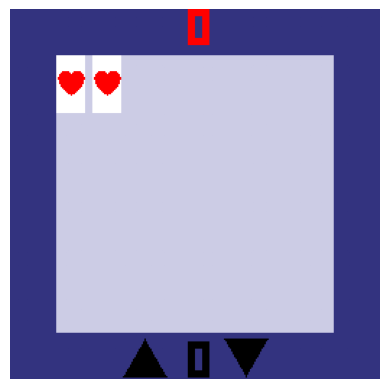

Finished tracing + transforming ravel for pjit in 0.000000000 sec
Finished tracing + transforming threefry_2x32 for pjit in 0.002398252 sec
Finished tracing + transforming _threefry_split_original for pjit in 0.004408121 sec
Finished tracing + transforming _threefry_split for pjit in 0.005409479 sec
Compiling _threefry_split with global shapes and types [ShapedArray(uint32[2])]. Argument mapping: (UnspecifiedValue,).
Finished tracing + transforming _bitwise_xor for pjit in 0.000000000 sec
Finished tracing + transforming _add for pjit in 0.000000000 sec
Finished tracing + transforming _add for pjit in 0.000000000 sec
Finished tracing + transforming _add for pjit in 0.001016617 sec
Finished tracing + transforming _subtract for pjit in 0.000000000 sec
Finished tracing + transforming _bitwise_or for pjit in 0.001000881 sec
Finished tracing + transforming _bitwise_xor for pjit in 0.000998259 sec
Finished tracing + transforming less for pjit in 0.000000000 sec
Finished jaxpr to MLIR module c

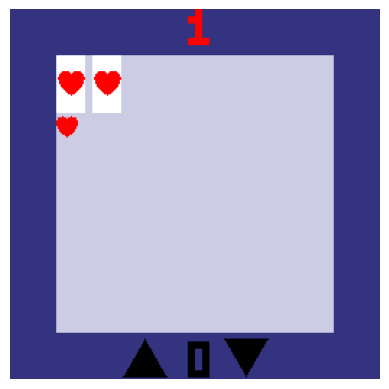

----------


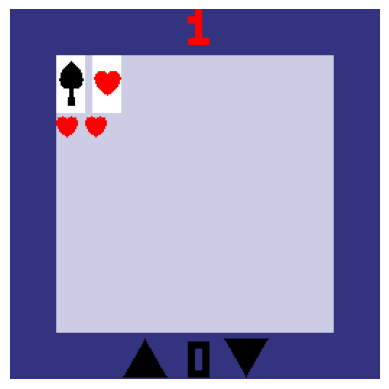

----------


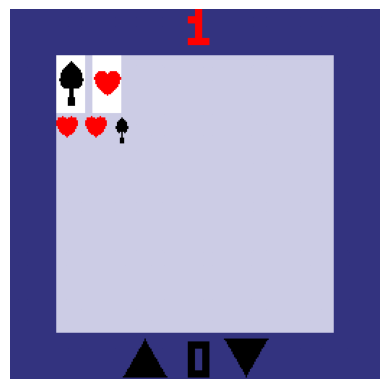

----------


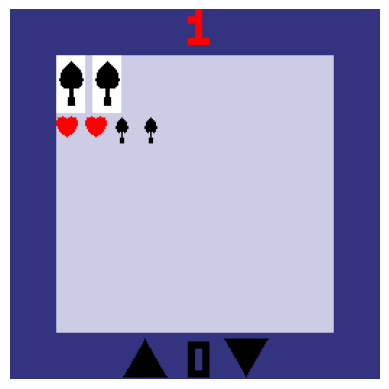

----------


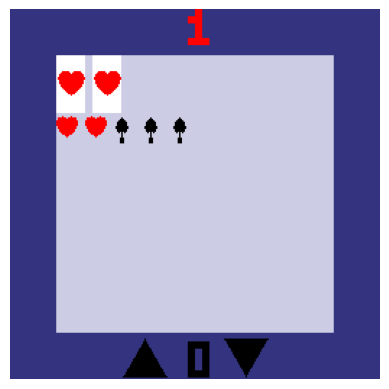

----------


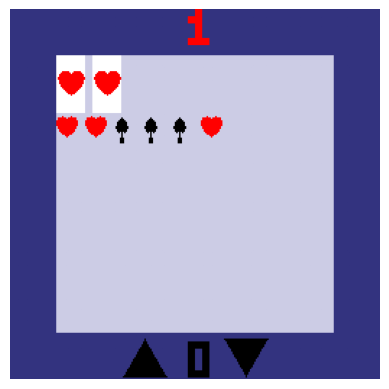

----------


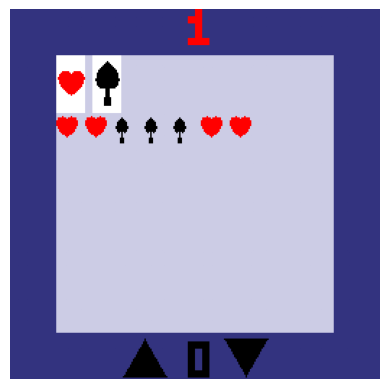

----------


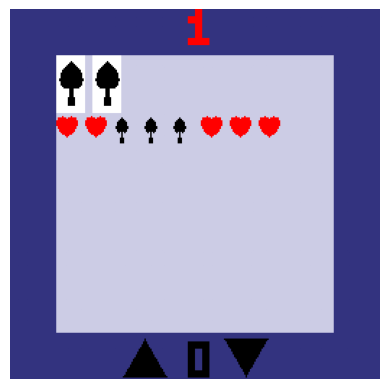

----------


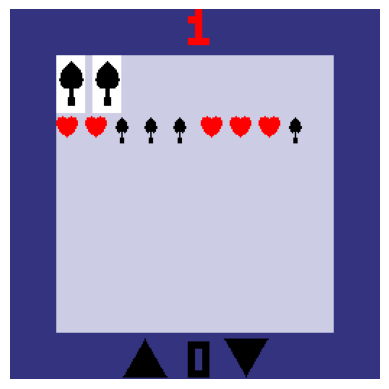

----------


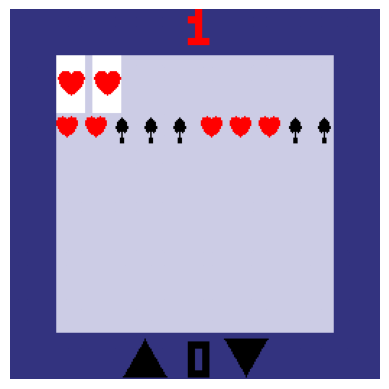

----------


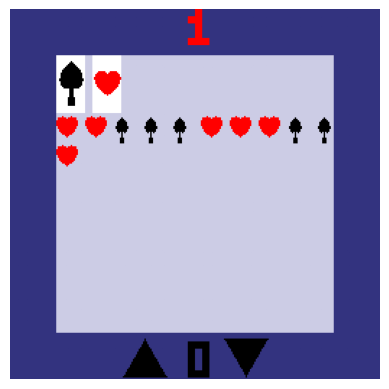

----------


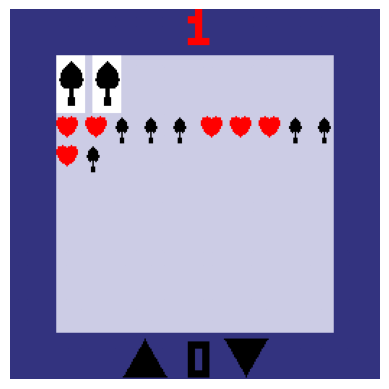

----------


In [1]:
import popjym
import jax
import jax.numpy as jnp
from matplotlib import pyplot as plt
from jax import lax


seed = jax.random.PRNGKey(0)
env, env_params = popjym.make("FullyObservableCountRecallEasy")
obs, state = env.reset(seed, env_params)
# print(f'observation: {obs}')
# print(f'obs[1]: {obs[1]}')

# print(f'value_card: {value_cards}')
# print(f'query_card: {query_cards}')
# print(f'history_card: {history_cards}')
# print(f'env.num_types: {env.num_types}')
# color = jnp.array([1.0, 1.0, 1.0])
with jax.log_compiles(True):
    countrecallrender = popjym.make_render("CountRecallRender")
    # reward = 0
    # score = 0
    # define a tuple to store state.timestep, env.num_types, score
    # tns = (state.timestep, env.num_types, score)
    # print(obs)
    # print(f'Initial State: {state}')
    
    # board = countrecallrender.render(obs, state.timestep, env.num_types, score)
    board = countrecallrender.render(state)
    plt.axis('off')
    plt.imshow(board)
    plt.show()
    # print(f'history from render: {history}')
    
    # while True:
    for i in range(5):
        key, subkey = jax.random.split(seed)
        # action = env.action_space(env_params).sample(subkey)
        action = 5
        # action = int(input("Input action (1, 2, 3, 4, 5): "))
        key, subkey2 = jax.random.split(key)
    
    
        obs, state, reward, done, info = env.step(subkey, state, action)
     
        # score = lax.cond(reward > 0, lambda _: score + 1, lambda _: score, operand=None)
    
        # print(f'state: {state}')
    
        board = countrecallrender.render(state)
        plt.axis('off')
        plt.imshow(board)
        plt.show()
        # print(f'history from render: {history}')
        
        # print(f'Obs: {obs}')
        # print(f'History: {obs[2 * env.num_types:]}')
        print('----------')
        if done:
            break
